# Note: In order for XGBoost to work, you need to pass all the inputs.
### In other words, please make sure that you aren't using the simple NN when you run XGBoost

In [1]:
import os

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"

import sys

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import MerfishDataset
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder
from spatial.train import train
from spatial.predict import test

In [2]:
# equivalent to spatial

import hydra
from hydra.experimental import compose, initialize

with initialize(config_path="../config"):
    cfg_from_terminal = compose(config_name="config")
    # for now just to keep the code running
    output = test(cfg_from_terminal)

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/roko/spatial//output/lightning_logs/checkpoints/MonetAutoencoder2D exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.3990674316883087}
--------------------------------------------------------------------------------


# MAE Imaging

In [3]:
import matplotlib.pyplot as plt

trainer, l1_losses, inputs, gene_expressions, celltypes = output

We can see in the source code that the cell types are listed as follows:

    cell_types = [
        "Ambiguous",
        "Astrocyte",
        "Endothelial 1",
        "Endothelial 2",
        "Endothelial 3",
        "Ependymal",
        "Excitatory",
        "Inhibitory",
        "Microglia",
        "OD Immature 1",
        "OD Immature 2",
        "OD Mature 1",
        "OD Mature 2",
        "OD Mature 3",
        "OD Mature 4",
        "Pericytes",
    ]
    
So, we can keep only the cell types the MESSI uses to evaluate their performance. These would be [1, 2, 6, 7, 8, 9, 10, 11]

#### For a single sample.

# FIX THIS TO BE BOXPLOT OVER ALL EXPRESSIONS

The code below simply identifies the response and non-response genes.

In [4]:
# read in merfish dataset and get columns names
import pandas as pd

# get relevant data stuff
df_file = pd.ExcelFile("~/spatial/data/messi.xlsx")
messi_df = pd.read_excel(df_file, "All.Pairs")
merfish_df = pd.read_csv("~/spatial/data/raw/merfish.csv")

# these are the 13 ligands or receptors found in MESSI
non_response_genes = ['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 
                      'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt',
                      'Tac2']
# this list stores the control genes aka "Blank_{int}"
blank_genes = []

# we will populate all of the non-response genes as being in one or the other
# the ones already filled in come from the existing 13 L/R genes above
ligands = ["Cbln1", "Cxcl14", "Cbln2", "Vgf", "Scg2", "Cartpt", "Tac2"]
receptors = ["Crhbp", "Gabra1", "Gpr165", "Glra3", "Gabrg1", "Adora2a"]

# ligands and receptor indexes in MERFISH
non_response_indeces = [list(merfish_df.columns).index(gene)-10 for gene in non_response_genes]
ligand_indeces = [list(merfish_df.columns).index(gene)-10 for gene in ligands]
receptor_indeces = [list(merfish_df.columns).index(gene)-10 for gene in receptors]
all_pairs_columns = [
    "Ligand.ApprovedSymbol",
    "Receptor.ApprovedSymbol",
]


# for column name in the column names above
for column in all_pairs_columns:
    for gene in merfish_df.columns:
        if (
            gene.upper() in list(messi_df[column])
            and gene.upper() not in non_response_genes
        ):
            non_response_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-10)
            if column[0] == "L":
                ligands.append(list(merfish_df.columns).index(gene)-10)
                ligand_indeces.append(list(merfish_df.columns).index(gene)-10)
            else:
                receptors.append(list(merfish_df.columns).index(gene)-10)
                receptor_indeces.append(list(merfish_df.columns).index(gene)-10)
        if gene[:5] == "Blank" and gene not in blank_genes:
            blank_genes.append(gene)
            non_response_indeces.append(list(merfish_df.columns).index(gene)-10)

print(non_response_genes)
print(
    "There are "
    + str(len(non_response_genes))
    + " genes recognized as either ligands or receptors (including new ones)."
)

print(
    "There are "
    + str(len(blank_genes))
    + " blank genes."
)

print(
    "There are "
    + str(160 - len(blank_genes) - len(non_response_genes))
    + " genes that are treated as response variables."
)

print(
    "There are "
    + str(len(ligands))
    + " ligands."
)

print(
    "There are "
    + str(len(receptors))
    + " receptors."
)

/home/roko/.cache/pypoetry/virtualenvs/spatial-G_n0JvVf-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


['Cbln1', 'Cxcl14', 'Crhbp', 'Gabra1', 'Cbln2', 'Gpr165', 'Glra3', 'Gabrg1', 'Adora2a', 'Vgf', 'Scg2', 'Cartpt', 'Tac2', 'Bdnf', 'Bmp7', 'Cyr61', 'Fn1', 'Fst', 'Gad1', 'Ntng1', 'Pnoc', 'Selplg', 'Sema3c', 'Sema4d', 'Serpine1', 'Adcyap1', 'Cck', 'Crh', 'Gal', 'Gnrh1', 'Nts', 'Oxt', 'Penk', 'Sst', 'Tac1', 'Trh', 'Ucn3', 'Avpr1a', 'Avpr2', 'Brs3', 'Calcr', 'Cckar', 'Cckbr', 'Crhr1', 'Crhr2', 'Galr1', 'Galr2', 'Grpr', 'Htr2c', 'Igf1r', 'Igf2r', 'Kiss1r', 'Lepr', 'Lpar1', 'Mc4r', 'Npy1r', 'Npy2r', 'Ntsr1', 'Oprd1', 'Oprk1', 'Oprl1', 'Oxtr', 'Pdgfra', 'Prlr', 'Ramp3', 'Rxfp1', 'Slc17a7', 'Slc18a2', 'Tacr1', 'Tacr3', 'Trhr']
There are 71 genes recognized as either ligands or receptors (including new ones).
There are 5 blank genes.
There are 84 genes that are treated as response variables.
There are 31 ligands.
There are 40 receptors.


The code below generates some MAE values separated by response status.

In [5]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

print(len(inputs), len(gene_expressions))

non_response_inputs = torch.index_select(inputs, 1, torch.tensor(non_response_indeces))
response_inputs = torch.index_select(inputs, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("Initial Response Expression Mean: " + str(response_inputs.mean().item()))
print("Initial Non-Response Expression Mean: " + str(non_response_inputs.mean().item()))

non_response_expressions =  torch.index_select(gene_expressions, 1, torch.tensor(non_response_indeces))
response_expressions = torch.index_select(gene_expressions, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("AE Response Expression Mean: " + str(response_expressions.mean().item()))
print("AE Non-Response Expression Mean: " + str(non_response_expressions.mean().item()))

mean_MAE_L1 = F.l1_loss(inputs.mean(axis=0), gene_expressions.mean(axis=0)).item()

print("Average L1 Loss for Mean " + str(mean_MAE_L1))

### L1 Losses 
# response_gene_boxplot = abs(inputs.mean(axis=0) - gene_expressions.mean(axis=0))
# print(pd.DataFrame(response_gene_boxplot).describe())
# plt.boxplot(response_gene_boxplot.reshape(1,-1))
# _ = plt.show()

mean_MAE_response_L1 = F.l1_loss(response_inputs.mean(axis=0), response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Response Genes: " + str(mean_MAE_response_L1.item()))

mean_MAE_non_response_L1 = F.l1_loss(non_response_inputs.mean(axis=0), non_response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Non-Response Genes: " + str(mean_MAE_non_response_L1.item()))

173509 173509
Initial Response Expression Mean: 1.7898056507110596
Initial Non-Response Expression Mean: 1.3080828189849854
AE Response Expression Mean: 1.442543864250183
AE Non-Response Expression Mean: 1.0776153802871704
Average L1 Loss for Mean 0.33867210149765015
Average L1 Loss for Mean among Response Genes: 0.4077150821685791
Average L1 Loss for Mean among Non-Response Genes: 0.26236143708229065


Now, we need to do the same thing, but separate the celltypes we care about.

In [6]:
import numpy as np
np.unique(celltypes[:,0])

array([3., 4., 5.], dtype=float32)

In [7]:
animals = [animal for animal, animal_id in enumerate(celltypes[:,0]) if animal_id in [3,4,5]]
cells = [cell for cell, celltype in enumerate(celltypes[:,1]) if celltype in [1, 2, 6, 7, 8, 9, 10, 11]]
print(len(animals), len(cells))

173509 117372


In [8]:
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

# filtering the inputs this time
filtered_inputs = torch.index_select(inputs, 0, torch.tensor(list(set(cells) | set(animals))))
filtered_gene_expressions = torch.index_select(gene_expressions, 0, torch.tensor(list(set(cells) | set(animals))))

non_response_inputs = torch.index_select(filtered_inputs, 1, torch.tensor(non_response_indeces))
response_inputs = torch.index_select(filtered_inputs, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("Initial Response Expression Mean: " + str(response_inputs.mean().item()))
print("Initial Non-Response Expression Mean: " + str(non_response_inputs.mean().item()))

non_response_expressions =  torch.index_select(filtered_gene_expressions, 1, torch.tensor(non_response_indeces))
response_expressions = torch.index_select(filtered_gene_expressions, 1, torch.tensor(list(set(range(160)) - set(non_response_indeces))))
print("AE Response Expression Mean: " + str(response_expressions.mean().item()))
print("AE Non-Response Expression Mean: " + str(non_response_expressions.mean().item()))

mean_MAE_L1 = F.l1_loss(filtered_inputs.mean(axis=0), filtered_gene_expressions.mean(axis=0)).item()

print("Average L1 Loss for Mean " + str(mean_MAE_L1))

# response_gene_boxplot = abs(filtered_inputs.mean(axis=0) - filtered_gene_expressions.mean(axis=0))
# print(pd.DataFrame(response_gene_boxplot).describe())
# plt.boxplot(response_gene_boxplot.reshape(1,-1))
# _ = plt.show()

mean_MAE_response_L1 = F.l1_loss(response_inputs.mean(axis=0), response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Response Genes: " + str(mean_MAE_response_L1.item()))

mean_MAE_non_response_L1 = F.l1_loss(non_response_inputs.mean(axis=0), non_response_expressions.mean(axis=0))
print("Average L1 Loss for Mean among Non-Response Genes: " + str(mean_MAE_non_response_L1.item()))

Initial Response Expression Mean: 1.7898056507110596
Initial Non-Response Expression Mean: 1.3080828189849854
AE Response Expression Mean: 1.442543864250183
AE Non-Response Expression Mean: 1.0776153802871704
Average L1 Loss for Mean 0.33867210149765015
Average L1 Loss for Mean among Response Genes: 0.4077150821685791
Average L1 Loss for Mean among Non-Response Genes: 0.26236143708229065


# Checklist of Things To Do:

- [x] Compare runs on tensorboard.
- [x] Ensure that outputs for every test example get saved (i.e. we should have a list of 31 tensors.) <b>No need. The tensor gets concatenated. We could create a tensor of tensors, but idk how helpful that is.</b>
- [x] Understand which anid, bregma correspond to which mouse and figure out how MESSI dealt with this. <b>Most animals have multiples bregmas and MESSI uses several animals (16-19) in their demo. </b>
- [x] Filter out outputs based on their respective celltype values (y).
- [x] Implement XGBoost on the 8 celltypes with pip install xgboost.
- [x] Make batch size hydra parameter.
- [x] Try multi-batch run with appropriate batch size and n_neighbors.
- [x] Change logger to only log MAE.
- [x] Add nbstripout to poetry.
- [x] Figure out how to label tensorboard folders.
- [x] Fix CUDA_VISIBLE_DEVICES <b>This is "fixed" but setting visible devices to more than 1 makes it "used" as a process even if a process doesn't get set to a GPU. Does being visible open up a process?</b>
- [x] Code up a basic NN that learns a single mean expression level for all genes.
- [ ] Hold out exact animals in testing batches.
- [x] Run the actual MESSI Notebook
- [ ] Explore different neighborhood methodologies.
    - [ ] Nearest Neighbor Graph
    - [ ] Dulaney Trinagulation
    - [ ] Gabriel Graph
    - [ ] Urquhart Graph (this will be a very good comparison to Dulaney Triangulation) <b>Not a priority, because more training should take care of this.</b> 
- [ ] Edge weights for MONET based on cell distances.

#### Now, let's add some regression into the mix!

In [9]:
import xgboost as xgb

This showcases the sizes of our data.

In [10]:
inputs.numpy().shape

(173509, 160)

In [11]:
celltypes.shape

torch.Size([173509, 2])

In [12]:
response_indeces = list(set(range(160)) - set(non_response_indeces))
len(response_indeces)

84

# Ideas

- [x] Try a more approximate solution.

# Replicating MESSI Results w/ XGBoost

- [x] Access the edge matrix so I can identify neighbors.
- [x] Get proportions (or counts) of celltypes for each neighbors.
- [x] Create ligand and receptor genes.
- [x] Get ligand expression of neighboring cells (AND SEE HOW MESSI STORES THIS DATA).
- [x] Include position coordinates.
- [ ] Figure out how XGBoost standardizes (SEE IF MESSI DOES)

See 1.2.4 in Supplementary Materials (defer to this for anything really), for more details.

In [13]:
def get_neighbors(batch_obj):
    return [batch_obj.edge_index[:, batch_obj.edge_index[0] == i][1] for i in range(batch_obj.x.shape[0])]

In [14]:
def get_ligand_sum(data, neighbors_tensor, ligand_indeces):
    return torch.tensor([torch.sum(data.index_select(0, neighbors).index_select(1, torch.tensor(ligand_indeces))).item() for neighbors in neighbors_tensor]).unsqueeze(1)

In [15]:
import torch.nn.functional as F

def get_celltypes(cell_behavior_tensor, neighbors_tensor):
    print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return [F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes) for neighbors in neighbors_tensor] 

In [16]:
def get_celltype_simplex(cell_behavior_tensor, neighbors_tensor):
    print(f"There are {(num_classes := cell_behavior_tensor.max() + 1)} different cell types.")
    return torch.cat([(torch.mean(1.0*F.one_hot(cell_behavior_tensor.index_select(0, neighbors), num_classes=num_classes), dim=0)).unsqueeze(0) for neighbors in neighbors_tensor], dim=0)

In [17]:
trial_run = MerfishDataset('data')

In [18]:
datalist = trial_run.construct_graphs(3, True)

In [19]:
X = datalist[0].x

In [20]:
behavior_and_cell_type = datalist[0].y

In [21]:
pos = datalist[0].pos

In [22]:
data = torch.cat((X, pos, behavior_and_cell_type), dim=1)

In [23]:
neighbors = get_neighbors(datalist[0])

In [24]:
get_ligand_sum(data, neighbors, ligand_indeces)

tensor([[47.2185],
        [47.1250],
        [38.7558],
        ...,
        [56.1281],
        [82.9202],
        [77.1233]])

In [25]:
get_celltypes(behavior_and_cell_type[:, 1], neighbors)

There are 16 different cell types.


[tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [26]:
get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)

There are 16 different cell types.


tensor([[0.0000, 0.6667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [27]:
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

scores_list = []

start = time.time()
for batch in datalist[:2]:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    X = torch.cat((torch.log1p(x[:, non_response_indeces]), pos, behavior_and_cell_type, total_ligands, celltype_proportions), dim=1)
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    for i in response_indeces:
        
        y = torch.log1p(x[:, i])
        model = xgb.XGBRegressor(tree_method="approx", nthread=1)


        # define model evaluation method
        cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=128)
        # the scores here stores the score (loss) for every CV fold and every repeat, so each one represents 
        # a single score.
        scores = cross_val_score(model, np.array(X), np.array(y), scoring='neg_mean_absolute_error', cv=cv, n_jobs=1, verbose=0, pre_dispatch=1)
        scores_list.append(scores)
        # force scores to be positive
        # scores = absolute(scores)
        print(f"Batch: {datalist.index(batch)+1}/{len(datalist)} Response Gene: {response_indeces.index(i)+1}/{len(response_indeces)}")

end = time.time()
print(end-start)

There are 16 different cell types.
Batch: 1/150 Response Gene: 1/84
Batch: 1/150 Response Gene: 2/84
Batch: 1/150 Response Gene: 3/84
Batch: 1/150 Response Gene: 4/84
Batch: 1/150 Response Gene: 5/84
Batch: 1/150 Response Gene: 6/84
Batch: 1/150 Response Gene: 7/84
Batch: 1/150 Response Gene: 8/84
Batch: 1/150 Response Gene: 9/84
Batch: 1/150 Response Gene: 10/84
Batch: 1/150 Response Gene: 11/84
Batch: 1/150 Response Gene: 12/84
Batch: 1/150 Response Gene: 13/84
Batch: 1/150 Response Gene: 14/84
Batch: 1/150 Response Gene: 15/84
Batch: 1/150 Response Gene: 16/84
Batch: 1/150 Response Gene: 17/84
Batch: 1/150 Response Gene: 18/84
Batch: 1/150 Response Gene: 19/84
Batch: 1/150 Response Gene: 20/84
Batch: 1/150 Response Gene: 21/84
Batch: 1/150 Response Gene: 22/84
Batch: 1/150 Response Gene: 23/84
Batch: 1/150 Response Gene: 24/84
Batch: 1/150 Response Gene: 25/84
Batch: 1/150 Response Gene: 26/84
Batch: 1/150 Response Gene: 27/84
Batch: 1/150 Response Gene: 28/84
Batch: 1/150 Response 

- [ ] Perhaps filter the data set to only include the animals that MESSI used.
- [x] Log1p transformation.
- [x] Use the transformation function from MESSI.


In [28]:
from data_processing import *

In [29]:
-np.mean(scores_list)

0.36660552636964155

<AxesSubplot:>

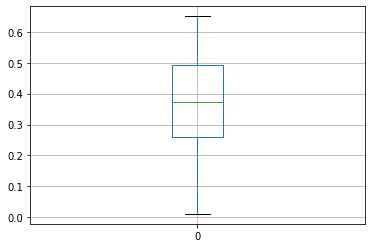

In [30]:
pd.DataFrame(-np.array(scores_list).reshape(-1)).boxplot()

# Testing XGBoost

## Training on Full Dataset

#### To Do

- [ ] Clean up notebook and better annotate it.
- [ ] Maybe turn for loop into a function that can be parallelized so that data doesn't take 2.5 minutes just to concatenate. Parallelize -> Just ONE torch.cat call on a list of tensors.
- [ ] Pickle Models (Mainly for Roman to practice serializing).

In [73]:
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

scores_list = []

start = time.time()

train_dataset = None

for batch in datalist:
    # gene expressions of cell i
    x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    X = torch.cat((torch.log1p(x[:, non_response_indeces]), pos, behavior_and_cell_type, total_ligands, celltype_proportions), dim=1)
    scaler = StandardScaler().fit(X)
    X = torch.tensor(scaler.transform(X))
    
    if train_dataset is None:
        train_dataset = X
        train_Y = x[:, response_indeces]
    else:
        train_dataset = torch.cat((train_dataset, X), dim=0)
        train_Y = torch.cat((train_Y, x[:, response_indeces]), dim=0)
        
    print(f"Batch: {datalist.index(batch)+1}/{len(datalist)}")

There are 16 different cell types.
Batch: 1/150
There are 16 different cell types.
Batch: 2/150
There are 16 different cell types.
Batch: 3/150
There are 16 different cell types.
Batch: 4/150
There are 16 different cell types.
Batch: 5/150
There are 16 different cell types.
Batch: 6/150
There are 16 different cell types.
Batch: 7/150
There are 16 different cell types.
Batch: 8/150
There are 16 different cell types.
Batch: 9/150
There are 16 different cell types.
Batch: 10/150
There are 16 different cell types.
Batch: 11/150
There are 16 different cell types.
Batch: 12/150
There are 16 different cell types.
Batch: 13/150
There are 16 different cell types.
Batch: 14/150
There are 16 different cell types.
Batch: 15/150
There are 16 different cell types.
Batch: 16/150
There are 16 different cell types.
Batch: 17/150
There are 16 different cell types.
Batch: 18/150
There are 16 different cell types.
Batch: 19/150
There are 16 different cell types.
Batch: 20/150
There are 16 different cell t

In [74]:
assert train_dataset.shape[0] == train_Y.shape[0]

In [75]:
test_datalist = trial_run.construct_graphs(3, False)

In [81]:
scores_list = []

test_dataset = None

for batch in test_datalist:
    # gene expressions of cell i
    test_x = batch.x
    # position coordinate of gene i
    pos = batch.pos
    # behavior and cell_type
    behavior_and_cell_type = batch.y
    
    # get the neighbors of the current batch
    neighbors = get_neighbors(batch)
    
    # get the sum of the ligand expressions for each cell in the current batch
    total_ligands = get_ligand_sum(test_x, neighbors, ligand_indeces)
    
    # get the proportion of celltypes as one-hot encoded vectors
    celltype_proportions = get_celltype_simplex(behavior_and_cell_type[:, 1], neighbors)
    
    # combine all the data
    test_X = torch.cat((torch.log1p(test_x[:, non_response_indeces]), pos, behavior_and_cell_type, total_ligands, celltype_proportions), dim=1)
    
    # standardize the data using TRAINING mean and sd.
    test_X = torch.tensor(scaler.transform(test_X))
    
    if test_dataset is None:
        test_dataset = test_X
        test_Y = test_x[:, response_indeces]
        print(test_dataset.shape[0], test_Y.shape[0])
    else:
        test_dataset = torch.cat((test_dataset, test_X), dim=0)
        test_Y = torch.cat((test_Y, test_x[:, response_indeces]), dim=0)
        
    print(f"Batch: {test_datalist.index(batch)+1}/{len(test_datalist)}")

There are 16 different cell types.
5815 5815
Batch: 1/31
There are 16 different cell types.
Batch: 2/31
There are 16 different cell types.
Batch: 3/31
There are 16 different cell types.
Batch: 4/31
There are 16 different cell types.
Batch: 5/31
There are 16 different cell types.
Batch: 6/31
There are 16 different cell types.
Batch: 7/31
There are 16 different cell types.
Batch: 8/31
There are 16 different cell types.
Batch: 9/31
There are 16 different cell types.
Batch: 10/31
There are 16 different cell types.
Batch: 11/31
There are 16 different cell types.
Batch: 12/31
There are 16 different cell types.
Batch: 13/31
There are 16 different cell types.
Batch: 14/31
There are 16 different cell types.
Batch: 15/31
There are 16 different cell types.
Batch: 16/31
There are 16 different cell types.
Batch: 17/31
There are 16 different cell types.
Batch: 18/31
There are 16 different cell types.
Batch: 19/31
There are 16 different cell types.
Batch: 20/31
There are 16 different cell types.
Batc

In [82]:
assert test_dataset.shape[0] == test_Y.shape[0]

In [ ]:
model_list = []
MAE_list = []

# for each response gene in our response matrix....
for i in range(train_Y.shape[1]):
    
    # create response gene variables
    y_i_train = train_Y[:, i]
    y_i_test = test_Y[:, i]
    
    # create XGBoost Regression Model
    model = xgb.XGBRegressor(tree_method="approx", nthread=1)

    # fit the regression model and add it to model list
    # print(train_dataset.shape, y_i_train.shape)
    model.fit(np.array(train_dataset), np.array(y_i_train))
    model_list.append((f"Gene {i}", model_list))

    # run the testing data through the model
    test_output = model.predict(np.array(test_dataset))
    
    # collect its MAE
    print(F.l1_loss(torch.tensor(test_output), y_i_test))
    MAE_list.append(F.l1_loss(test_output, y_i_test))
    
    print(MAE_list[-1])
    print(f"Response Gene: {response_indeces.index(i)+1}/{len(response_indeces)}")

end = time.time()
print(end-start)